In [ ]:
%pip install os
%pip install glob
%pip install numpy
%pip install cv2
%pip install time
%pip install opencv-python opencv-python-headless
%pip install Pillow
%pip install tensorflow
%pip install keras
%pip install scikit-learn
%pip install matplotlib
%pip install pandas

In [23]:
from math import log,ceil
import tensorflow as tf 
import os
import numpy as np
from PIL import Image
import threading
from tensorflow import keras
from keras import Sequential,Model
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D,LeakyReLU, MaxPooling2D, BatchNormalization, Dropout, Dense,Conv2DTranspose, Flatten, Reshape, AveragePooling2D
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import Input, Dense, Reshape, Flatten
from keras.optimizers import Adam

In [4]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:

# Function to recursively find .asm files in a directory
def find_asm_files(directory):
    asm_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".bytes"):
                asm_files.append(os.path.join(root, file))
    return asm_files
asm_files = find_asm_files('./')

# SAVE IMAGE FUNCTION

In [4]:
#=================================================================================
def saveimg(array,name):
    print(name)
    print(array.shape)
    if array.shape[1]!=16:
        assert(False)
    b=int((array.shape[0]*16)**(0.5))
    b=2**(int(log(b)/log(2))+1)
    a=int(array.shape[0]*16/b)
    print(a,b,array.shape)
    array=array[:int(a*b/16),:]

    array=np.reshape(array,(a,b))
     
    im = Image.fromarray(np.uint8(array))
    im.save("F:/malware-classification/trainImagesBW/" + name[:-6]+'.png', "PNG")

In [ ]:
from PIL import Image

def crop_image(input_path, output_path):
    # Open the image file
    original_image = Image.open(input_path)

    # Get the dimensions of the original image
    width, height = original_image.size

    # Set the coordinates to crop the image to 512x512
    left = (width - 512) / 2
    top = (height - 512) / 2
    right = (width + 512) / 2
    bottom = (height + 512) / 2

    # Crop the image
    cropped_image = original_image.crop((left, top, right, bottom))

    # Save the cropped image
    cropped_image.save(output_path)

# Example usage
input_image_path = "../Dynamic-Malware-Detection-using-Generative-AI/GANBang/Colored_2DBKbxPnVCyiLzqAHU.png"
output_image_path = "./cropped_image.jpg"

crop_image(input_image_path, output_image_path)


# GRAY-SCALE IMAGE GENERATOR

In [ ]:
asm_files = find_asm_files('./')

def process_file(x):
    
    f=open(x)
    x = x[9:]
    array=[]
    for line in f:
        xx=line.split()
        if len(xx)!=17:
            continue
        array.append([int(i,16) if i!='??' else 0 for i in xx[1:]])
    saveimg(np.array(array),x)
    del array
    f.close() 
    
def process_files_in_thread(asm_files):
    for file_path in asm_files:
        process_file(file_path)

asm_files = find_asm_files('../train/')

num_threads = 8
chunk_size = len(asm_files) // num_threads
file_chunks = [asm_files[i:i+chunk_size] for i in range(0, len(asm_files), chunk_size)]

threads = []

for chunk in file_chunks:
    thread = threading.Thread(target=process_files_in_thread, args=(chunk,))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

# COLORED IMAGES GENERATOR

In [15]:
def find_png_files(directory):
    png_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            png_files.append(os.path.join(root, file))
    return png_files

In [ ]:


def process_file(file_path):
    grayscale_image = np.array(Image.open(file_path))


    height, width = grayscale_image.shape
    rgb_image = np.empty((height, width, 3), dtype=np.uint8)

    # Map the intensity values to colors
    for intensity in range(256):
        if 0 <= intensity <= 85:
            # Map to red
            rgb_image[grayscale_image == intensity] = [255, 0, 0]
        elif 86 <= intensity <= 170:
            # Map to green
            rgb_image[grayscale_image == intensity] = [0, 255, 0]
        elif 171 <= intensity <= 255:
            # Map to blue
            rgb_image[grayscale_image == intensity] = [0, 0, 255]

    # Save the RGB image
    i = file_path[17:len(file_path)-4]
    print(i)
    output_image = Image.fromarray(rgb_image)
    output_image.save("F:/malware-classification/TrainImagesColor/" + i + ".png")

def process_files_in_thread(asm_files):
    for file_path in asm_files:
        process_file(file_path)

# asm_files = find_asm_files('./train')
png_files = find_png_files("../trainImagesBW/")
print(png_files[:10])
# Split the list of files into 4 equal parts
num_threads = 8
chunk_size = len(png_files) // num_threads
file_chunks = [png_files[i:i+chunk_size] for i in range(0, len(png_files), chunk_size)]

# Create threads
threads = []

for chunk in file_chunks:
    thread = threading.Thread(target=process_files_in_thread, args=(chunk,))
    threads.append(thread)
    thread.start()

# Wait for all threads to finish
for thread in threads:
    thread.join()

# Generate Resized Images of Size 512 x 512

In [20]:
def process_file(file_path):
    image = Image.open(file_path)

    target_width = 128
    target_height = 128
    image = cv2.imread(file_path)
    res = cv2.resize(image, (target_width,target_height))
    # resized_image = image.resize((target_width, target_height))
    i = file_path[20:len(file_path)-4]
    cv2.imwrite("F:/malware-classification/TrainImagesColorResized128/" + i + ".png", res)
    # res.save("F:/malware-classification/TrainImagesColorResized128/" + i + ".png")


def process_files_in_thread(asm_files):
    for file_path in asm_files:
        process_file(file_path)

# asm_files = find_asm_files('./train')
png_files = find_png_files("../TrainImagesColor/")
num_threads = 8
chunk_size = len(png_files) // num_threads
file_chunks = [png_files[i:i+chunk_size] for i in range(0, len(png_files), chunk_size)]

threads = []

for chunk in file_chunks:
    thread = threading.Thread(target=process_files_in_thread, args=(chunk,))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

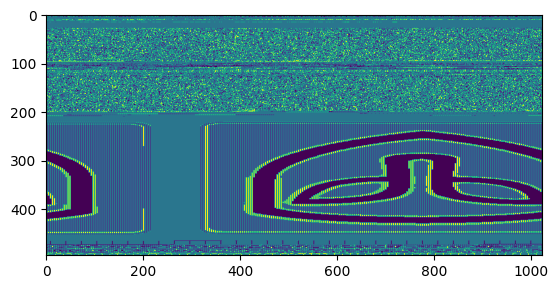

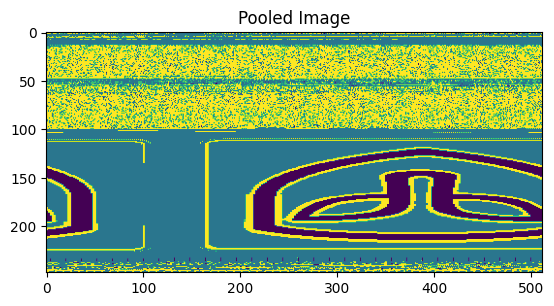

In [12]:
def spatial_pooling(image, pool_size):

    height, width = image.shape

    # Calculate the new dimensions after pooling
    new_height = height // 2
    new_width = width // 2
    # Initialize an array to store the pooled image
    pooled_image = np.zeros((new_height, new_width))
    
    # Apply spatial pooling
    for i in range(0, new_height):
        for j in range(0, new_width):
            # Calculate the region for pooling
            region = image[i*pool_size:(i+1)*pool_size, j*pool_size:(j+1)*pool_size]
            # Take the maximum value within the region
            pooled_image[i, j] = np.max(region)
    
    return pooled_image

image = cv2.imread("./GANBang/Colored_2DBKbxPnVCyiLzqAHU.png", cv2.IMREAD_GRAYSCALE)

pool_size = 2

pooled_image = spatial_pooling(image, pool_size)

plt.imshow(image)
plt.show()
plt.imshow(pooled_image)
plt.title('Pooled Image')
plt.show()

# SIZE PREDCTION 128 x 128
### totally made it up

In [15]:
# Define the architecture
malwareModel = Sequential()
malwareModel.add(Conv2D(4,(3,3),input_shape=(512, 512, 3)))
malwareModel.add(LeakyReLU(0.25))
malwareModel.add(MaxPooling2D((3,3)))
malwareModel.add(BatchNormalization())
malwareModel.add(Dropout(0.25))
malwareModel.add(Conv2D(8,(3,3),input_shape=(170, 170, 4)))
malwareModel.add(LeakyReLU(0.25))
malwareModel.add(Flatten())
malwareModel.add(Dense(100))
malwareModel.add(LeakyReLU(0.25))
malwareModel.compile(optimizer='adam', metrics=['accuracy'], loss="mse")

# Define a sample image size
sample_image_size = (512, 512, 3)

# Generate a random sample image
sample_image = np.random.rand(*sample_image_size)

# Add an extra dimension to mimic batch size of 1
sample_image = np.expand_dims(sample_image, axis=0)

# Get the output shape after passing through the model
output_shape = malwareModel.predict(sample_image).shape[1:]

# Calculate the total size
total_size = np.prod(output_shape)

print(f"The image size for an initial dense layer size of 13,440 is: {total_size}")


1/1 [==============================] - 0s 322ms/step
The image size for an initial dense layer size of 13,440 is: 100


# Images loaded to RAM for model

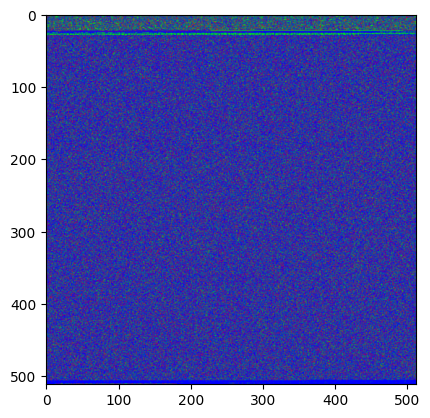

In [5]:
def load_images_from_directory(directory_path):
    images = []
    imagePaths = []
    for root, dirs, files in os.walk(directory_path):
        sum = 0
        for file in files:
            if sum == 1000:
                break
            if file.endswith(".png"):
                image_path = os.path.join(root, file)
                imagePaths.append(image_path[27:len(image_path) - 4])
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = image / 255.0  # Normalize pixel values
                images.append(image)
                sum += 1
    
    return images,imagePaths

result = load_images_from_directory("../TrainImagesColorResized/")
plt.imshow(result[0][0])
plt.show()

In [6]:
df = pd.read_csv('../Analysis-Kaggle-Work/trainLabels.csv')
labelsDictionary = df.set_index('Id')['Class'].to_dict()

In [7]:
trainingSet = result[0]
trainingSet = np.array(trainingSet)
trainingLabels = [labelsDictionary[result[1][i]] for i in range(len(result[1]))]
trainingLabels = np.array(trainingLabels)

In [8]:
print(len(trainingSet))
print(result[1][1],labelsDictionary[result[1][1]],trainingLabels[1])

1000
01IsoiSMh5gxyDYTl4CB 2 2


# Models


In [46]:
def makeEncoder():
    encoder = Sequential()
    encoder.add(Conv2D(4,(3,3),input_shape=(512, 512, 3)))
    encoder.add(LeakyReLU(alpha=0.25))
    encoder.add(MaxPooling2D((3,3)))
    encoder.add(BatchNormalization())
    encoder.add(Dropout(0.25))
    encoder.add(Conv2D(8,(3,3),input_shape=(170, 170, 4)))
    encoder.add(LeakyReLU(alpha=0.25))
    encoder.add(Flatten())
    encoder.add(Dense(100))
    encoder.add(LeakyReLU(alpha=0.25))
    encoder.compile(optimizer='adam', metrics=['accuracy'], loss="mse")
    return encoder

def makeDecoder(encoder):
    decoder = encoder
    decoder.add(Dense(12288))
    decoder.add(LeakyReLU(alpha=0.25))
    decoder.add(Reshape((64, 64, 3)))
    decoder.add(Conv2DTranspose(128, (3, 3)))
    decoder.add(LeakyReLU(alpha=0.25))
    decoder.add(Conv2D(64, (3, 3)))
    decoder.add(LeakyReLU(alpha=0.25))
    decoder.add(Conv2DTranspose(64, (3, 3)))
    decoder.add(LeakyReLU(alpha=0.25))
    decoder.add(Conv2D(32, (3, 3)))
    decoder.add(LeakyReLU(alpha=0.25))
    decoder.add(Conv2D(1, (3, 3)))
    decoder.add(LeakyReLU(alpha=0.25))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    decoder.compile(metrics=['accuracy'], loss="mse",optimizer=optimizer)
    return decoder

def makeGenerator(autoencoder):
    generator = Sequential()
    generator.add(autoencoder)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
    generator.compile(optimizer=optimizer, metrics=['accuracy'], loss="mse")
    return generator

def makeDiscriminator(generator):
    discriminator = generator
    discriminator.add(Conv2D(4,(3,3)))
    discriminator.add(LeakyReLU(alpha=0.25))
    discriminator.add(AveragePooling2D((3,3)))
    discriminator.add(Conv2D(8,(3,3)))
    discriminator.add(LeakyReLU(alpha=0.25))
    discriminator.add(AveragePooling2D((3,3)))
    discriminator.add(Flatten())
    discriminator.add(Dense(128, activation='relu'))
    discriminator.add(Dense(2, activation='relu'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    return discriminator

def makeMalwareDetector(GAN):
    malwareDetector = Sequential()
    for layer in GAN.layers[:-2]:
        malwareDetector.add(layer)
    malwareDetector.add(Dense(128, activation='relu'))
    malwareDetector.add(Dense(9, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    malwareDetector.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    return malwareDetector
    


    # 3 × 3Conv@4 – 3 × 3AveragePooling – 3 × 3Conv@8 – 3 × 3AveragePooling – Fully connected layer of size 128–9
malwareModel = makeEncoder()
malwareModel = makeDecoder(malwareModel)
malwareModel = makeGenerator(malwareModel)
malwareModel = makeDiscriminator(malwareModel)
malwareModel = makeMalwareDetector(malwareModel)
malwareModel.summary()
X_train, X_test, y_train, y_test = train_test_split(trainingSet, trainingLabels, test_size=0.3, random_state=42)
malwareModel.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test))
test_loss, test_accuracy = malwareModel.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_53 (Sequential)  (None, 62, 62, 1)         23953869  
                                                                 
 conv2d_168 (Conv2D)         (None, 60, 60, 4)         40        
                                                                 
 leaky_re_lu_275 (LeakyReLU)  (None, 60, 60, 4)        0         
                                                                 
 average_pooling2d_32 (Avera  (None, 20, 20, 4)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_169 (Conv2D)         (None, 18, 18, 8)         296       
                                                                 
 leaky_re_lu_276 (LeakyReLU)  (None, 18, 18, 8)        0         
                                                     

Trying another technique (Training the models separately)

In [25]:
def makeEncoder():
    encoder = Sequential()
    encoder.add(Conv2D(4,(3,3),input_shape=(512, 512, 3)))
    encoder.add(LeakyReLU(alpha=0.25))
    encoder.add(MaxPooling2D((3,3)))
    encoder.add(BatchNormalization())
    encoder.add(Dropout(0.25))
    encoder.add(Conv2D(8,(3,3),input_shape=(170, 170, 4)))
    encoder.add(LeakyReLU(alpha=0.25))
    encoder.add(Flatten())
    encoder.add(Dense(100))
    encoder.add(LeakyReLU(alpha=0.25))
    encoder.compile(optimizer='adam', metrics=['accuracy'], loss="mse")
    return encoder

def makeDecoder(encoder):
    decoder = encoder
    decoder.add(Dense(12288))
    decoder.add(LeakyReLU(alpha=0.25))
    decoder.add(Reshape((64, 64, 3)))
    decoder.add(Conv2DTranspose(128, (3, 3)))
    decoder.add(LeakyReLU(alpha=0.25))
    decoder.add(Conv2D(64, (3, 3)))
    decoder.add(LeakyReLU(alpha=0.25))
    decoder.add(Conv2DTranspose(64, (3, 3)))
    decoder.add(LeakyReLU(alpha=0.25))
    decoder.add(Conv2D(32, (3, 3)))
    decoder.add(LeakyReLU(alpha=0.25))
    decoder.add(Conv2D(1, (3, 3)))
    decoder.add(LeakyReLU(alpha=0.25))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    decoder.compile(metrics=['accuracy'], loss="mse",optimizer=optimizer)
    return decoder


malwareModel = makeEncoder()
malwareModel = makeDecoder(malwareModel)


X_train, X_test, y_train, y_test = train_test_split(trainingSet, trainingLabels, test_size=0.3, random_state=42)
malwareModel.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test))

#for transferring the weights to the GAN
malwareModel.save_weights('dae_weights.h5')



test_loss, test_accuracy = malwareModel.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)



In [26]:
def buildGenerator():
    generator = Sequential()
    generator.add(Dense(12288))
    generator.add(LeakyReLU(alpha=0.25))
    generator.add(Reshape((64, 64, 3)))
    generator.add(Conv2DTranspose(128, (3, 3)))
    generator.add(LeakyReLU(alpha=0.25))
    generator.add(Conv2D(64, (3, 3)))
    generator.add(LeakyReLU(alpha=0.25))
    generator.add(Conv2DTranspose(64, (3, 3)))
    generator.add(LeakyReLU(alpha=0.25))
    generator.add(Conv2D(32, (3, 3)))
    generator.add(LeakyReLU(alpha=0.25))
    generator.add(Conv2D(1, (3, 3)))
    generator.add(LeakyReLU(alpha=0.25))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
    generator.compile(metrics=['accuracy'], loss="mse", optimizer=optimizer)
    return generator
    
    
    
def buildDiscriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(4,(3,3)))
    discriminator.add(LeakyReLU(alpha=0.25))
    discriminator.add(AveragePooling2D((3,3)))
    discriminator.add(Conv2D(8,(3,3)))
    discriminator.add(LeakyReLU(alpha=0.25))
    discriminator.add(AveragePooling2D((3,3)))
    discriminator.add(Flatten())
    discriminator.add(Dense(128, activation='relu'))
    discriminator.add(Dense(2, activation='relu'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    return discriminator
    
    

In [29]:
def train(epochs, batch_size=128, save_interval=10):
    
    #Training Discriminator
    X_train, X_test, y_train, y_test = train_test_split(trainingSet, trainingLabels, test_size=0.3, random_state=42)
    # X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    # X_train = np.expand_dims(X_train, axis=3)
    half_batch = int(batch_size / 2)
    
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        
        gen_imgs = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        #Training Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)
        
        g_loss = combined.train_on_batch(noise, valid_y)
        
        print("%d [D loss: %f, acc. : %.2f%%] [G loss: %f]" %(epoch, d_loss[0], 100*d_loss[1], g_loss))
        
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [ ]:
# Training combined model
optimizer = keras.optimizers.Adam(0.0001, 0.5)

discriminator = buildDiscriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = buildGenerator()
generator.load_weights('dae_weights.h5')
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(12288,))
img = generator(z)

discriminator.trainable = False
valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

train(epochs=100, batch_size=32, save_interval=5)
generator.save('generator_model_test.h5')

In [ ]:
from keras.models import load_model

# Load the trained generator model
generator = load_model('generator_model_test.h5')

# Generate new images
noise = np.random.normal(0, 1, size=(10, 100))
generated_images = generator.predict(noise)

# Rescale images from [-1, 1] to [0, 1]
generated_images = (generated_images + 1) / 2.0

# Plot the generated images
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(generated_images[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()

# Problems while using pooling techniques

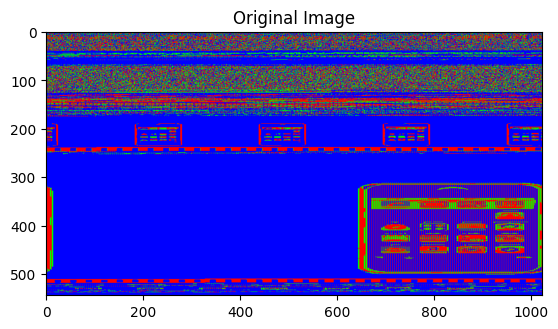

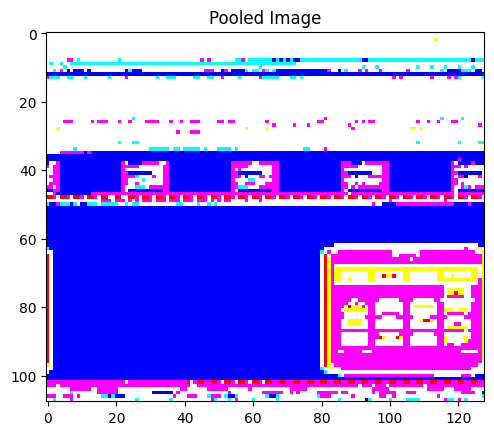

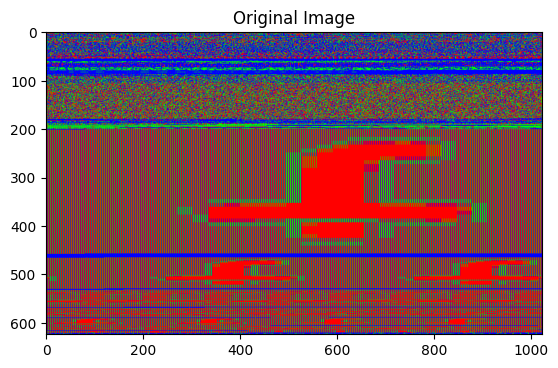

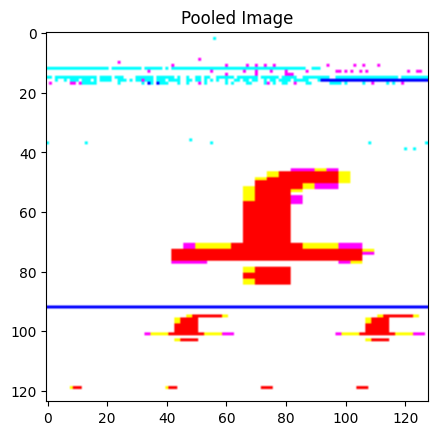

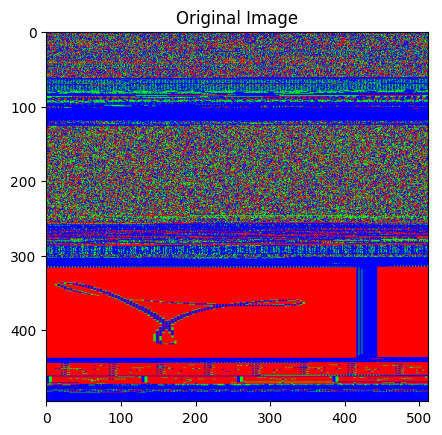

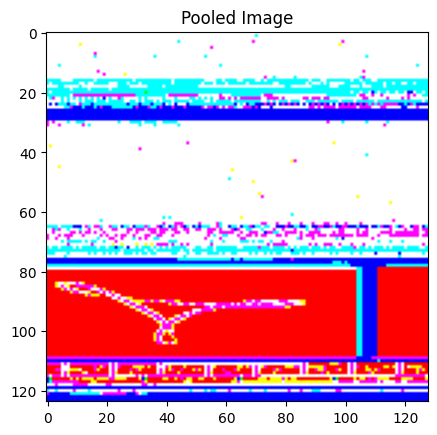

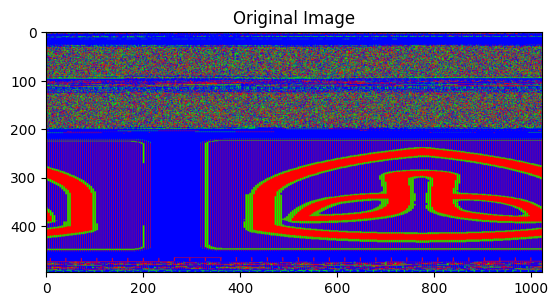

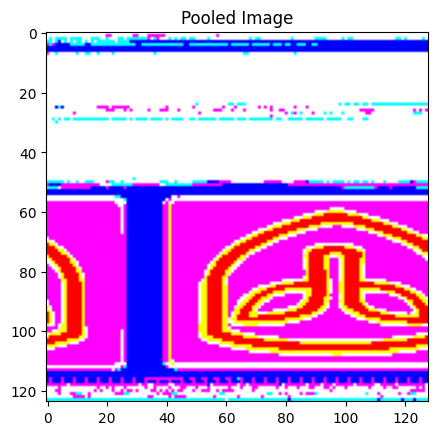

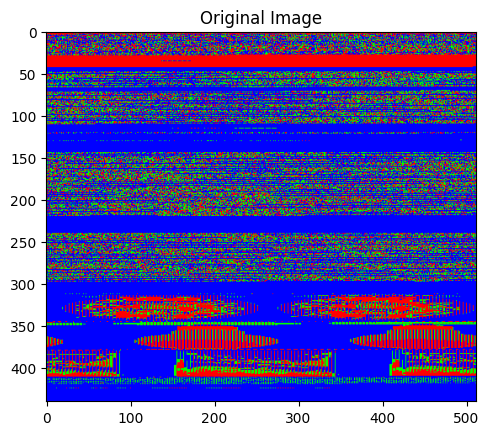

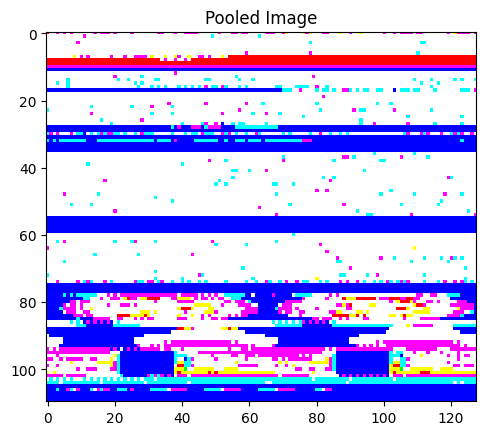

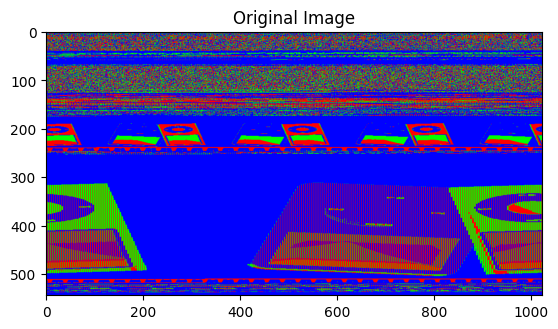

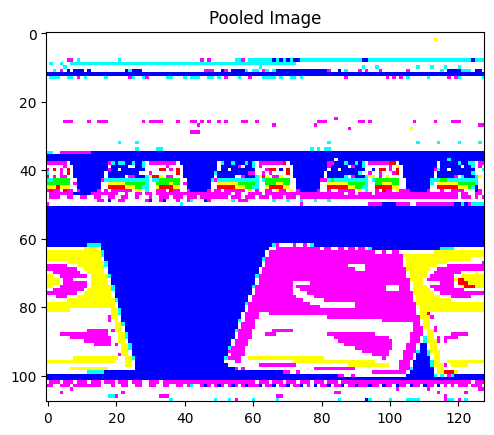

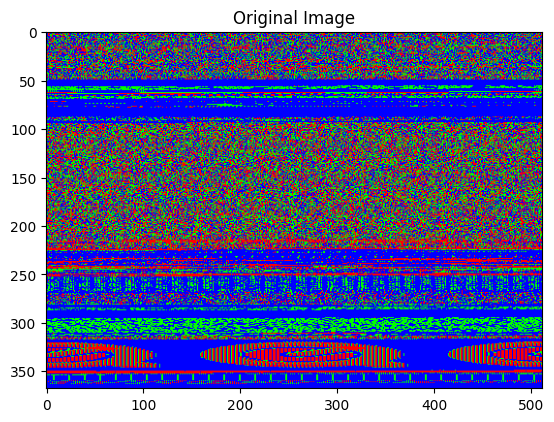

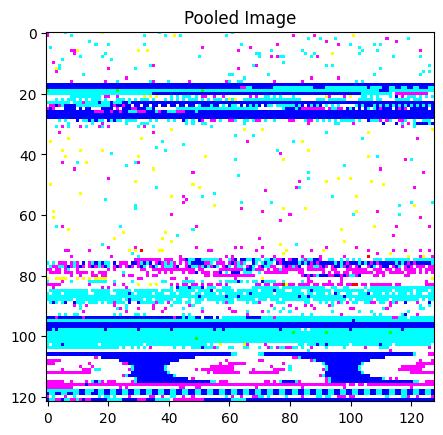

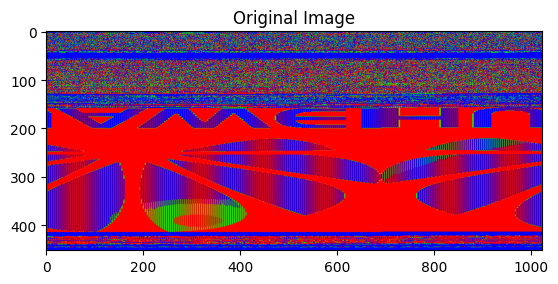

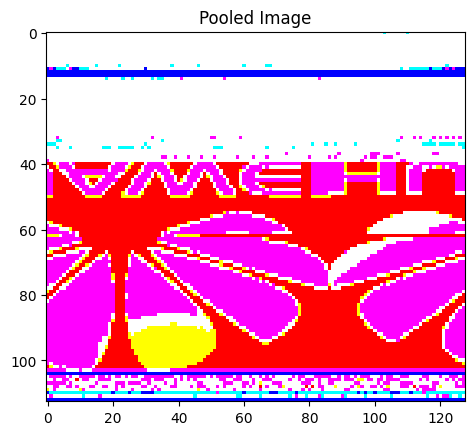

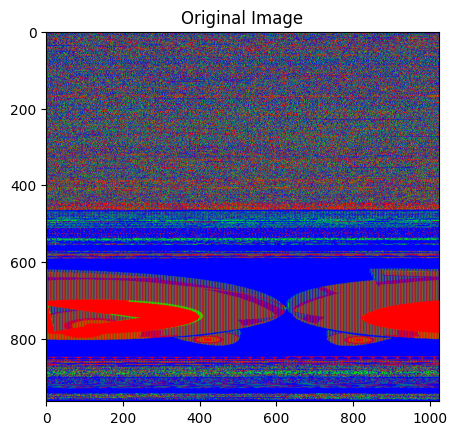

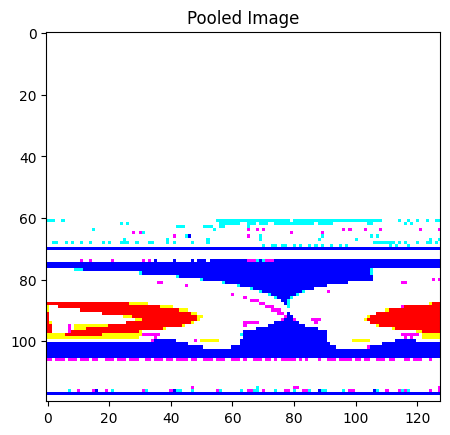

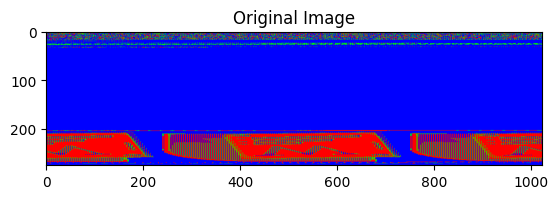

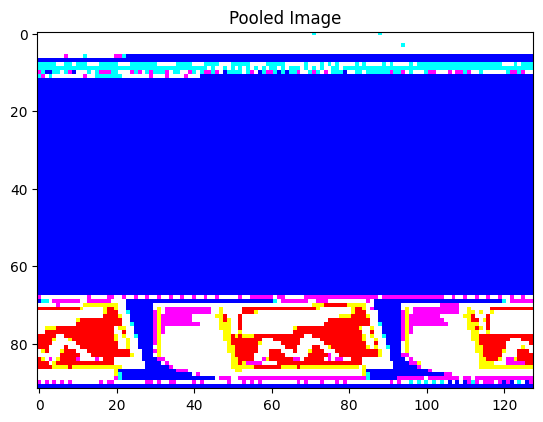

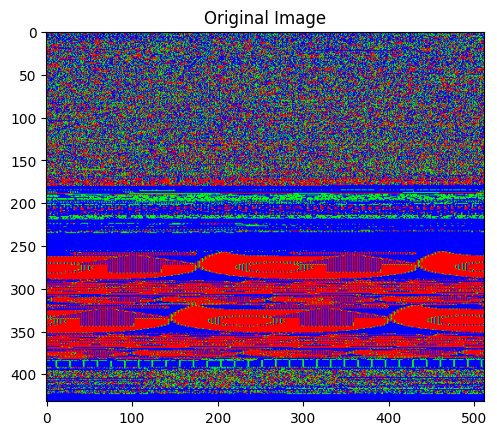

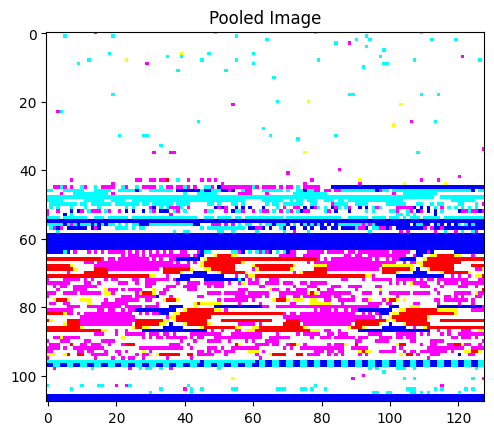

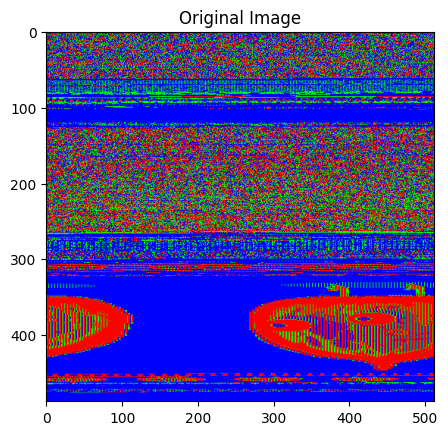

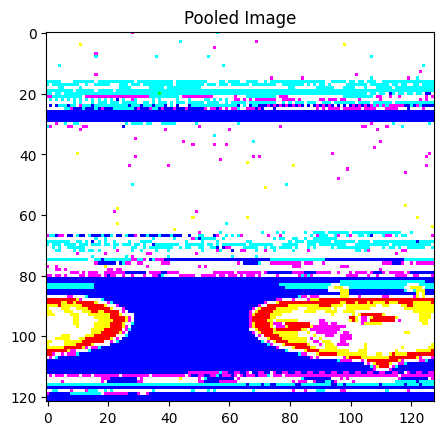

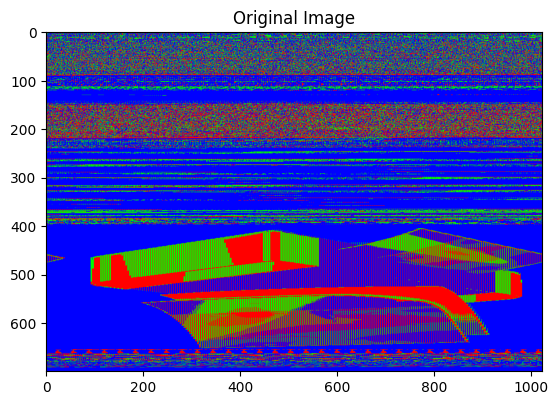

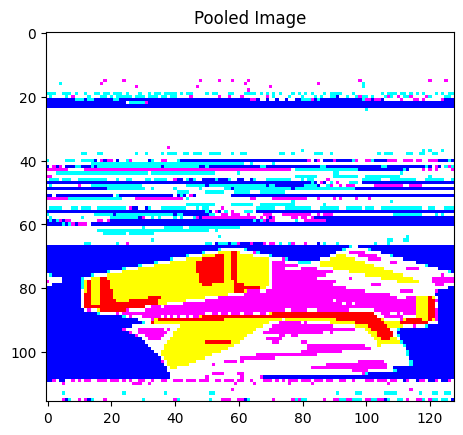

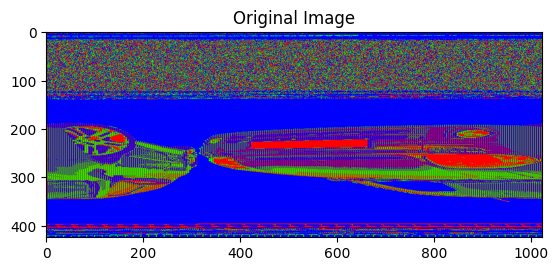

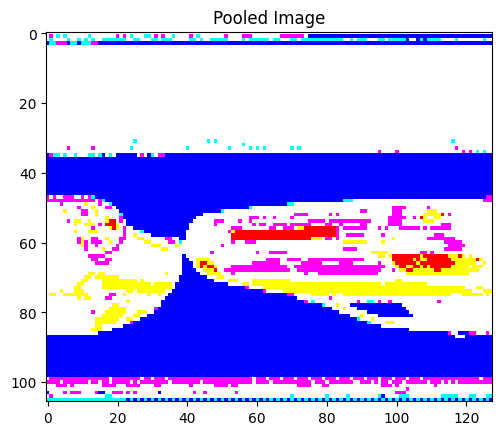

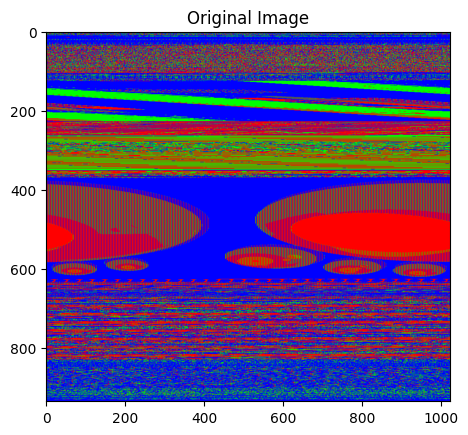

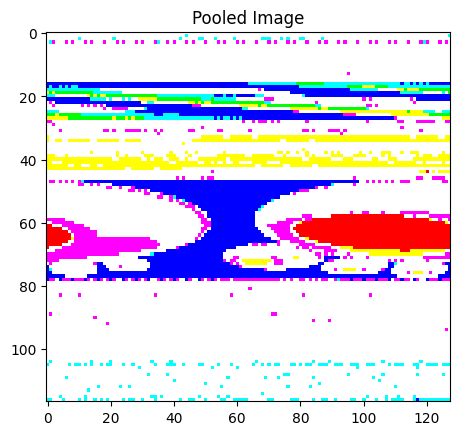

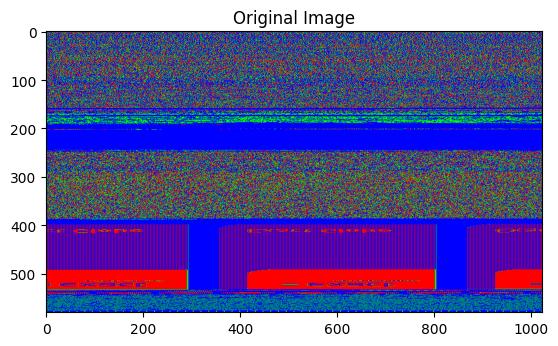

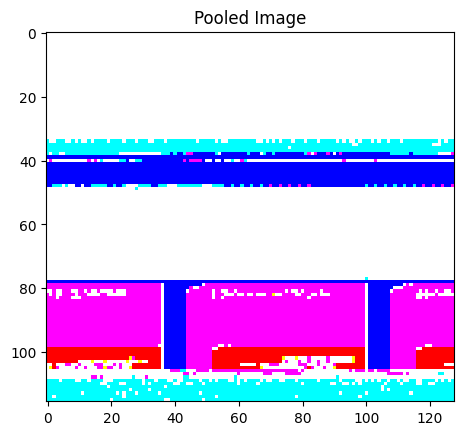

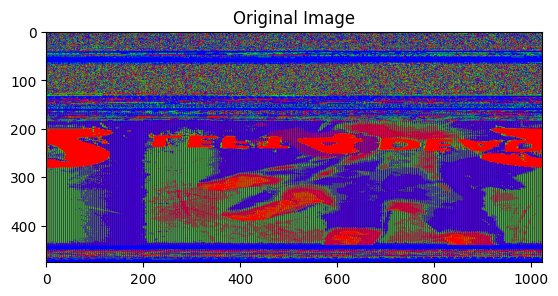

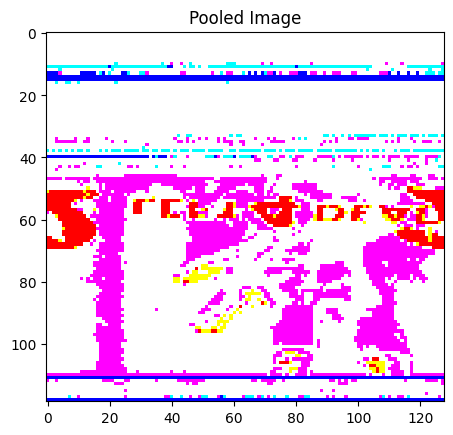

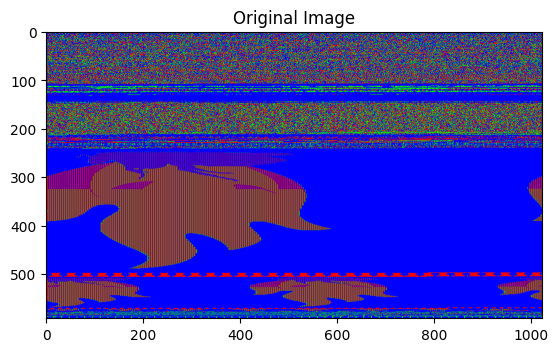

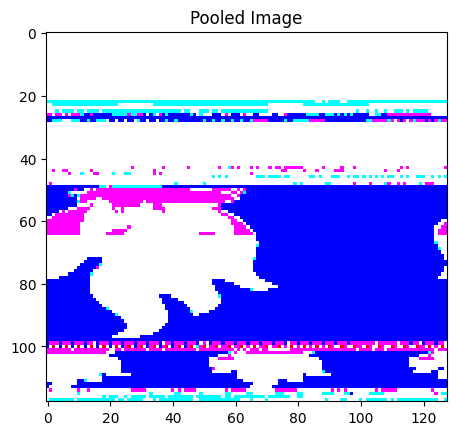

In [10]:
def max_pooling(image, pool_size):
    pooled_image = np.zeros((image.shape[0]//pool_size[0], image.shape[1]//pool_size[1], image.shape[2]), dtype=np.uint8)
    for i in range(pooled_image.shape[0]):
        for j in range(pooled_image.shape[1]):
            for k in range(pooled_image.shape[2]):
                pooled_image[i, j, k] = np.max(image[i*pool_size[0]:(i+1)*pool_size[0], j*pool_size[1]:(j+1)*pool_size[1], k])
    return pooled_image

imagesPicked = find_png_files("./GANBang/")
for images in imagesPicked:
    image_path = images 
    image = cv2.imread(image_path)
    height, width, channels = image.shape
    targetPoolingHeight = ceil(height / 128)
    targetPoolWidth = ceil(width/128)
    pooling_size = (targetPoolingHeight, targetPoolWidth)
    pooling_result = max_pooling(image, pooling_size)
    plt.title("Original Image")
    plt.imshow(image)
    plt.show()
    plt.title("Pooled Image")
    plt.imshow(pooling_result)
    plt.show()




In [37]:
number = 13440
import math
for i in range(2,1000):
    num = number/i
    if math.sqrt(num) == int(math.sqrt(num)): 
        print("Answer: " + str(math.sqrt(num)) + " number: " + str(i))

Answer: 8.0 number: 210
Answer: 4.0 number: 840
